In [25]:
# Import des libraries

from bigml.api import BigML
import pandas
from pandas import read_csv
import matplotlib

In [29]:
# Fonctions

def threshold(row):
    if row['1 probability'] < threshold_value:
        prediction_value = 0
    else: 
        prediction_value = 1
    return prediction_value

def error_column(row):
    if(row['SeriousDlqin2yrs'] == 0 and row['prediction'] == 0):
        error_value = 'TN'
    if(row['SeriousDlqin2yrs'] == 1 and row['prediction'] == 0):
        error_value = 'FN'
    if(row['SeriousDlqin2yrs'] == 0 and row['prediction'] == 1):
        error_value = 'FP'
    if(row['SeriousDlqin2yrs'] == 1 and row['prediction'] == 1):
        error_value = 'TP'
    return error_value

def confusion_matrix():
    idx = pandas.Index(df['error'])
    count_matrix = idx.value_counts() 
    return count_matrix

def get_accuracy():
    matrix = list(df.error.values)
    tn = matrix.count('TN')
    fn = matrix.count('FN')
    tp = matrix.count('TP')
    fp = matrix.count('FP')
    total = tn + fn + tp + fp
    accuracy = ((tp + tn ) / total ) * 100
    return accuracy

def get_profits():
    matrix = list(df.error.values)
    val_tn = 500
    val_fn = -2500
    val_tp = 0
    val_fp = -500
    profits = matrix.count('TN') * val_tn + matrix.count('FN') * val_fn + matrix.count('TP') * val_tp + matrix.count('FP') * val_fp
    return profits

# On cherche parmis les FN ( Prediction = 0 , Réalité  = 1 ) les plus petites 1 Proba ( Le modele prédisait quasi certainement 0)
def biggest_mistakes():
    filtered = df.loc[df['error'].isin(["FN"])]
    filtered = (filtered.nsmallest(100, '1 probability'))
    filtered.to_csv("100_biggest_mistakes.csv")
    return filtered

In [30]:
# Définition du seuil

threshold_value = 0.5

In [31]:
# Chargement de la feuille csv & applications des modifications
import pandas

df = pandas.read_csv('Prediction2.csv', index_col=0)
df.rename(columns={"SeriousDlqin2yrs.1": "prediction"}, inplace= True)
df['prediction'] = df.apply(threshold, axis = 1)
df['error'] = df.apply(error_column, axis = 1)
print("Load & Modifications : OK")

Load & Modifications : OK


In [32]:
# Matrice de confusion

confusion_matrix()

TN    27717
FN     1663
TP      352
FP      268
Name: error, dtype: int64

In [33]:
# Accuracy

get_accuracy()

93.56333333333333

In [34]:
# Profits

get_profits()

9567000

In [35]:
# 100 plus grosses erreurs de notre modèle ( Parmis les FN , + petites 1 proba)

biggest_mistakes()
print("Enregistrement du fichier .csv en local :  OK")

Enregistrement du fichier .csv en local :  OK


In [36]:
# fonction(threshold) = profits

def cost_threshold(threshold):
    # Return True si 1 Proba > seuil & False si 1 Proba < seuil
    prediction_threshold = df['1 probability'] > threshold
    
    P_pred = prediction_threshold # Renvoie True si 1 proba > seuil ( sinon False )
    N_pred = ~prediction_threshold # Renvoie True si 1 proba < seuil ( sinon False )
    
    P_real = (df['SeriousDlqin2yrs'] == 1) # Renvoie True si SeriousDlqin2Yrs == 1 ( sinon False )
    N_real = (df['SeriousDlqin2yrs'] == 0) # Renvoie True si SeriousDlqin2Yrs == 0 ( sinon False )
    
    # P_pred True si 1 proba > seuil Prediction =  1 , P_real True si Realite = 1 
    TP = len(df.loc[P_pred & P_real])
    # N_pred True = si 1 proba < seuil = Prediction = 0 , N_real True si Realité 0 
    TN = len(df.loc[N_pred & N_real])
    # P_pred True si 1 proba > seuil Prediction = 1 , N_real True si Réalite = 0
    FP = len(df.loc[P_pred & N_real])
    # N_pred True si 1 proba < seuil =  Prediction 0 , P_real True si Realité = 1
    FN = len(df.loc[N_pred & P_real])
    
    TP_cost = 0
    FN_cost = -2500
    FP_cost = -500
    TN_cost = 500
    
    cost = TP * TP_cost
    cost += TN * TN_cost
    cost += FP * FP_cost
    cost += FN * FN_cost
    
    return cost

gain max 9980000 $ | Seuil 0.287


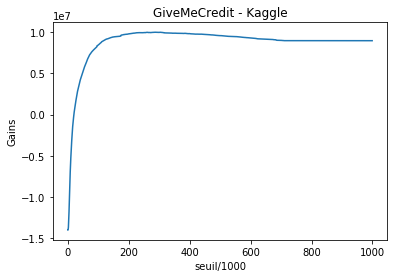

In [37]:
# Graphique et affichage du seuil opti

import matplotlib.pyplot as plt
# on fait varier le seuil de 0 à 1000 / 1000 => 0.0001 , 0.0002 ... 1 dans la fonction seuil => gain
table = [cost_threshold(n/1000) for n in range(0,1000)]
plt.xlabel("seuil/1000")
plt.ylabel("Gains")
plt.title("GiveMeCredit - Kaggle")

plt.plot(table)

max_val = max(table)
max_threshold = table.index(max_val)/1000
print(f'gain max {max_val} $ | Seuil {max_threshold}')

In [ ]:
# calcul de l'AUC

In [7]:
# Methode Laurent

# Tri des données pour préparer le calcul de AUC

df = read_csv('Prediction2.csv', index_col=0)
df_sorted = df.sort_values('1 probability', ascending=False)
df

#  Calcul de la somme des négatifs en dessous de chaque positifs (1 probability est inférieur)

N_sum_below = 0
for index in range(len(df_sorted)):
    if df_sorted['SeriousDlqin2yrs'].iloc[index] == 1:
        N_sum_below += df_sorted['SeriousDlqin2yrs'][index+1:].value_counts().loc[0]

print(N_sum_below)

# Calcul du produit nombre N * nombre P
N_number = df_sorted['SeriousDlqin2yrs'].value_counts().loc[0]
P_number  = df_sorted['SeriousDlqin2yrs'].value_counts().loc[1]
NP_product = N_number * P_number

# Calcul auc
AUC = N_sum_below / NP_product
AUC

48254957


0.8557394846849451

In [28]:
# Methode Maud

df = read_csv('Prediction2.csv', index_col=0)

positive = (df['SeriousDlqin2yrs'] == 1)
nb_positive=len(df.loc[positive])
nb_negative=len(df.loc[~positive])

result = df[['SeriousDlqin2yrs','1 probability']]
threshold_list = result.sort_values(by='1 probability',ascending=False)['SeriousDlqin2yrs'].values


auc = 0
P_cumul = 0

for i in range(len(threshold_list)):
    if threshold_list[i] == 1:
        P_cumul += 1
    else:
        auc += P_cumul
        
auc = auc/(nb_positive*nb_negative)

auc

0.8557394846849451